> [scVelo](https://scvelo.readthedocs.io/VelocityBasics/)

# RNA Velocity Basics

Here you will learn the basics of RNA velocity analysis.

For illustration, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. See here for more details. It can be applied to your own data along the same lines.

The notebook is also available at Google Colab and nbviewer.

In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
%load_ext rpy2.ipython
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

ModuleNotFoundError: No module named 'scvelo'

# Integrating Loom File and Meta-data

In [ ]:
sample_obs = pd.read_csv("./4.4-scVelo/cellID_obs.csv")
umap = pd.read_csv("./4.4-scVelo/cell_embeddings_umap.csv")
cell_clusters = pd.read_csv("./4.4-scVelo/clusters.csv")

In [ ]:
sample_obs

In [4]:
sample = anndata.read_loom("./4.4-scVelo/merged.loom")
sample

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 109487 × 31053
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [5]:
sample.obs_names

Index(['P_LI_D21_B2:AAAGTCCTCTGGACCGx', 'P_LI_D21_B2:AAACGAAGTTTCTTACx',
       'P_LI_D21_B2:AAAGAACGTATGTCCAx', 'P_LI_D21_B2:AAAGGTAGTTCTATCTx',
       'P_LI_D21_B2:AAAGGTATCTATGTGGx', 'P_LI_D21_B2:AAAGTGAGTTACTCAGx',
       'P_LI_D21_B2:AAATGGATCCTAGCTCx', 'P_LI_D21_B2:AAACGAAGTGGAACACx',
       'P_LI_D21_B2:AAAGGTACATAGAGGCx', 'P_LI_D21_B2:AAAGTGAAGAGTGAAGx',
       ...
       'E_LI_D135_B1:TTGGTTTGTCGATGCCx', 'E_LI_D135_B1:TTGTGTTAGGATACATx',
       'E_LI_D135_B1:TTTGACTGTTGGTAGGx', 'E_LI_D135_B1:TTTGGAGGTAGGAGGGx',
       'E_LI_D135_B1:TTTCATGCACCTGCAGx', 'E_LI_D135_B1:TTTCATGGTGGTCTTAx',
       'E_LI_D135_B1:TTGTTTGTCTCTGAGAx', 'E_LI_D135_B1:TTGGTTTTCGCTGTTCx',
       'E_LI_D135_B1:TTTATGCGTGACTCGCx', 'E_LI_D135_B1:TTTCCTCGTGGTGATGx'],
      dtype='object', length=109487)

In [6]:
# Only keep cells from seurat object
sample = sample[np.isin(sample.obs.index,sample_obs["x"])]
sample

View of AnnData object with n_obs × n_vars = 72609 × 31053
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [7]:
# order cells from umap coordinate
sample_index = pd.DataFrame(sample.obs.index)
sample_index = sample_index.rename(columns = {0:'CellID'})
umap = umap.rename(columns = {'Unnamed: 0':'CellID'})
umap_ordered = sample_index.merge(umap,on="CellID")

In [8]:
# Add umap coordinate to Anndata object
umap_ordered = umap_ordered.iloc[:,1:]
sample.obsm['X_umap'] = umap_ordered.values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1]:
# reorder cell_cluster
cell_clusters = cell_clusters.rename(columns = {'cells':'CellID'})
clusters_ordered = sample_index.merge(cell_clusters,on="CellID")

NameError: name 'cell_clusters' is not defined

In [ ]:
clusters_ordered
clusters_ordered.columns == 'Merged-Harmony_snn_res.0.6'
clusters_ordered.columns[38]

In [12]:
# Add cluster info to Anndata object
clusters_ordered = clusters_ordered.iloc[:,38]
sample.obs['clusters'] = np.array(clusters_ordered)

# Running RNA Velocity

## Load the Data

In [13]:
sample

AnnData object with n_obs × n_vars = 72609 × 31053
    obs: 'Clusters', '_X', '_Y', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

scVelo is based on adata, an object that stores a data matrix adata.X, annotation of observations adata.obs, variables adata.var, and unstructured annotations adata.uns. Names of observations and variables can be accessed via adata.obs_names and adata.var_names, respectively. AnnData objects can be sliced like dataframes, for example, adata_subset = adata[:, list_of_gene_names]. For more details, see the anndata docs.

In [14]:
sample.obs['clusters'] = sample.obs['clusters'].astype('category').values

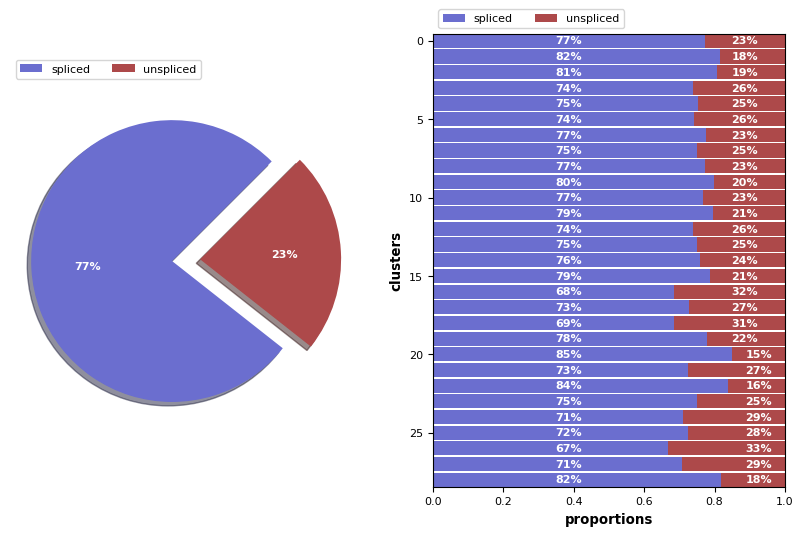

In [15]:
scv.pl.proportions(sample,figsize=(10,6))

Here, the proportions of spliced/unspliced counts are displayed. Depending on the protocol used (Drop-Seq, Smart-Seq), we typically have between 10%-25% of unspliced molecules containing intronic sequences. We also advice you to examine the variations on cluster level to verify consistency in splicing efficiency. Here, we find variations as expected, with slightly lower unspliced proportions at cycling ductal cells, then higher proportion at cell fate commitment in Ngn3-high and Pre-endocrine cells where many genes start to be transcribed.

## Preprocess the Data

Preprocessing requisites consist of gene selection by detection (with a minimum number of counts) and high variability (dispersion), normalizing every cell by its total size and logarithmizing X. Filtering and normalization is applied in the same vein to spliced/unspliced counts and X. Logarithmizing is only applied to X. If X is already preprocessed from former analysis, it will not be touched.

Further, we need the first and second order moments (means and uncentered variances) computed among nearest neighbors in PCA space, summarized in scv.pp.moments, which internally computes scv.pp.pca and scv.pp.neighbors. First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [16]:
scv.pp.filter_and_normalize(sample, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(sample, n_pcs=30, n_neighbors=30)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 15725 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:40) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


Further preprocessing (such as batch effect correction) may be used to remove unwanted sources of variability. See the best practices for further details. Note, that any additional preprocessing step only affects X and is not applied to spliced/unspliced counts.

## Estimate RNA velocity

Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. The velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default) or deterministically (by setting mode='deterministic'). For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are then obtained as residuals from this ratio. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

The solution to the full dynamical model is obtained by setting mode='dynamical', which requires to run scv.tl.recover_dynamics(adata) beforehand. We will elaborate more on the dynamical model in the next tutorial.

In [17]:
scv.tl.velocity(sample)

computing velocities
    finished (0:00:43) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


The computed velocities are stored in adata.layers just like the count matrices.

The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated. That is, for each velocity vector we find the likely cell transitions that are accordance with that direction. The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph. The resulting velocity graph has dimension nobs×nobs and summarizes the possible cell state changes that are well explained through the velocity vectors (for runtime speedup it can also be computed on reduced PCA space by setting approx=True).

In [18]:
scv.tl.velocity_graph(sample)

computing velocity graph
    finished (0:13:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


For a variety of applications, the velocity graph can be converted to a transition matrix by applying a Gaussian kernel to transform the cosine correlations into actual transition probabilities. You can access the Markov transition matrix via scv.utils.get_transition_matrix.

As mentioned, it is internally used to project the velocities into a low-dimensional embedding by applying the mean transition with respect to the transition probabilities, obtained with scv.tl.velocity_embedding. Further, we can trace cells along the Markov chain to their origins and potential fates, thereby getting root cells and end points within a trajectory, obtained via scv.tl.terminal_states.

## Project the velocities

Finally, the velocities are projected onto any embedding, specified by basis, and visualized in one of these ways: - on cellular level with scv.pl.velocity_embedding, - as gridlines with scv.pl.velocity_embedding_grid, - or as streamlines with scv.pl.velocity_embedding_stream.

Note, that the data has an already pre-computed UMAP embedding, and annotated clusters. When applying to your own data, these can be obtained with scv.tl.umap and scv.tl.louvain. For more details, see the scanpy tutorial. Further, all plotting functions are defaulted to using basis='umap' and color='clusters', which you can set accordingly.



computing velocity embedding
    finished (0:00:25) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


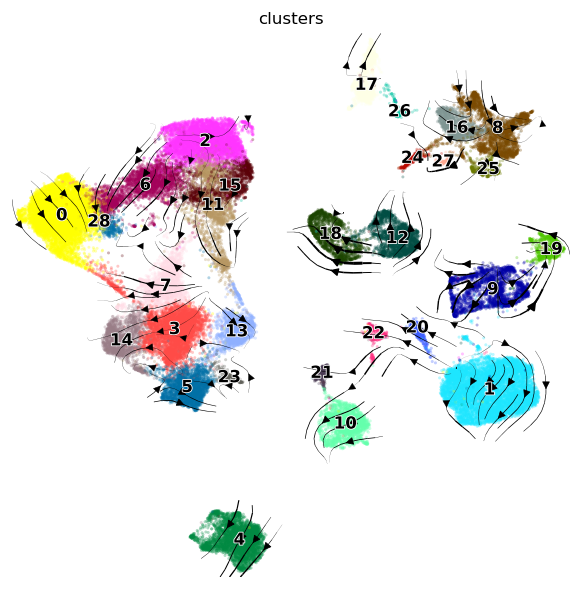

In [19]:
scv.pl.velocity_embedding_stream(sample, basis='umap',dpi = 120)

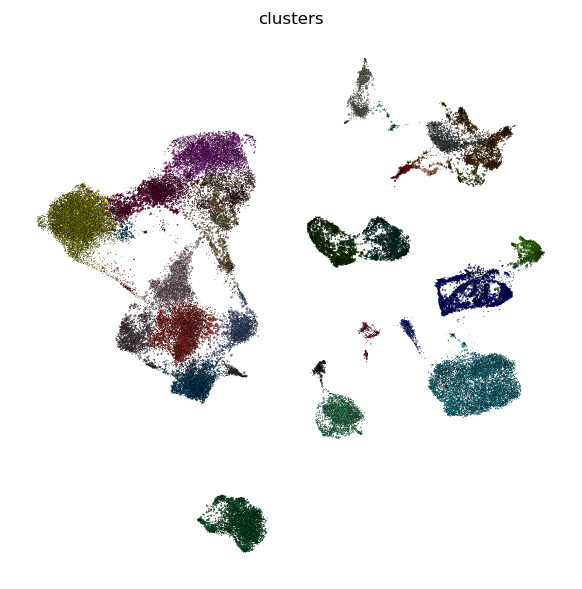

In [20]:
scv.pl.velocity_embedding(sample, arrow_length=5, arrow_size=4, dpi=120)

The velocity vector field displayed as streamlines yields fine-grained insights into the developmental processes. It accurately delineates the cycling population of ductal cells and endocrine progenitors. Further, it illuminates cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation.

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell. That reveals, e.g., the early endocrine commitment of Ngn3-cells (yellow) and a clear-cut difference between near-terminal α-cells (blue) and transient β-cells (green).

## You may want to try dynamical mode

In [21]:
scv.tl.recover_dynamics(sample, n_jobs = 24)
scv.tl.velocity(sample, mode='dynamical')
scv.tl.velocity_graph(sample)
scv.pl.velocity_embedding_stream(sample, basis='umap',dpi = 120)

## Interprete the velocities

This is perhaps the most important part as we advise the user not to limit biological conclusions to the projected velocities, but to examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes.

See the gif here to get an idea of how to interpret a spliced vs. unspliced phase portrait. Gene activity is orchestrated by transcriptional regulation. Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait.

Now, let us examine the phase portraits of some marker genes, visualized with scv.pl.velocity(adata, gene_names) or scv.pl.scatter(adata, gene_names).

In [22]:
#var_names = ['Malat1', 'Cdh13', 'Fstl4', 'Prdm6']
#scv.pl.velocity(sample, var_names=var_names, colorbar=True, ncols=2)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1296x0 with 0 Axes>

The black line corresponds to the estimated ‘steady-state’ ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

For instance Cpe explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while Adk explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

In [24]:
# scv.pl.scatter(sample, 'Malat1', color=['clusters', 'velocity'],
#                add_outline='1, 0')

IndentationError: unexpected indent (<ipython-input-24-970d30c2c201>, line 2)

# Identify important genes

We need a systematic way to identify genes that may help explain the resulting vector field and inferred lineages. To do so, we can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [25]:
scv.tl.rank_velocity_genes(sample, groupby='clusters', min_corr=.3)

df = scv.DataFrame(sample.uns['rank_velocity_genes']['names'])
df.head(20)

ranking velocity genes
    finished (0:00:29) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,Col4a5,Top2a,Grem2,Adamts2,Muc16,Lhfpl2,Frem2,Mylk,Rel,Mecom,...,Naip5,Vcan,Lama4,Hmga2,Notch3,Mir142hg,Dock8,Pecam1,Sirpa,Col5a2
1,Pde3a,Vcan,Carmn,Mgll,Podxl,Aldh1a1,Map1b,Sema3a,Mir142hg,Sema3c,...,Nr3c2,Pde3a,4930578C19Rik,Col3a1,Pde3a,Dock2,Rtn1,Gm15987,Srgn,Cenpf
2,Cadm2,Ptch1,Sema3a,Dnm3os,Frem2,Slit2,Ptger3,Lama2,Dock8,Gpr35,...,Sidt1,Tshz2,Arhgap29,Plagl1,Pdgfrb,Mirt1,Mir142hg,Serinc3,Arhgap25,Knl1
3,Ano1,Pdgfra,Itga1,Lama2,Sema3d,Zim1,Carmn,Svep1,Nfkbid,Slc17a4,...,Ptpn18,Ptch1,Fgd5,H19,Aspn,Ptk2b,Prkcb,Ripor2,Abca1,Ano1
4,Dkk2,Pde3a,Hhip,Fbln1,Sema3a,Nrp1,Postn,Isl1,Zeb2,Fam83b,...,Itga6,Synpo2,Ptpre,Abcc9,Ccdc80,Samsn1,Myo1f,Inpp5d,St8sia4,Id2
5,2600014E21Rik,Lpp,Itih5,Col5a1,Megf6,Sned1,Col16a1,Hhip,Cd83,Myo5c,...,Ern2,Pdgfra,Sned1,Sfrp1,Adamts1,Ets2,Dock2,Mef2c,Apbb1ip,Notch3
6,Scn3a,Notch3,Col6a2,Calcrl,Epha4,Piezo2,Mest,Fhl1,Parp14,Ptpn18,...,Rapgef5,Myocd,Arap3,Fstl1,Mylk,Myo1f,Apobec3,Fam169b,Lyst,Fstl1
7,Igfbp5,Ano1,Hmcn2,Fosb,Colec10,Tshz2,Abcc9,Postn,Tnfaip3,Naip6,...,Myo5c,Ano1,Lhfpl2,Fbn1,Rnf152,Tnfrsf1b,Dock10,Cd274,Nfkbid,Top2a
8,Nrk,Synpo2,Frem2,Svep1,Il16,Maf,Cnr1,Dnm3os,Srgn,Anxa2,...,Naip6,Notch3,Adgrg3,Col14a1,Stat1,B430306N03Rik,Nlrc5,Ikzf3,Nlrp3,Lamb1
9,Pde4b,Col4a5,Nr4a2,Dpysl3,Angptl2,Slc26a7,Kcnj8,Epha5,Arhgap25,Itga6,...,Hk2,Lpp,Ptprb,Ltbp4,Col28a1,Hck,Apbb1ip,Prkcb,Rab11fip1,2600014E21Rik


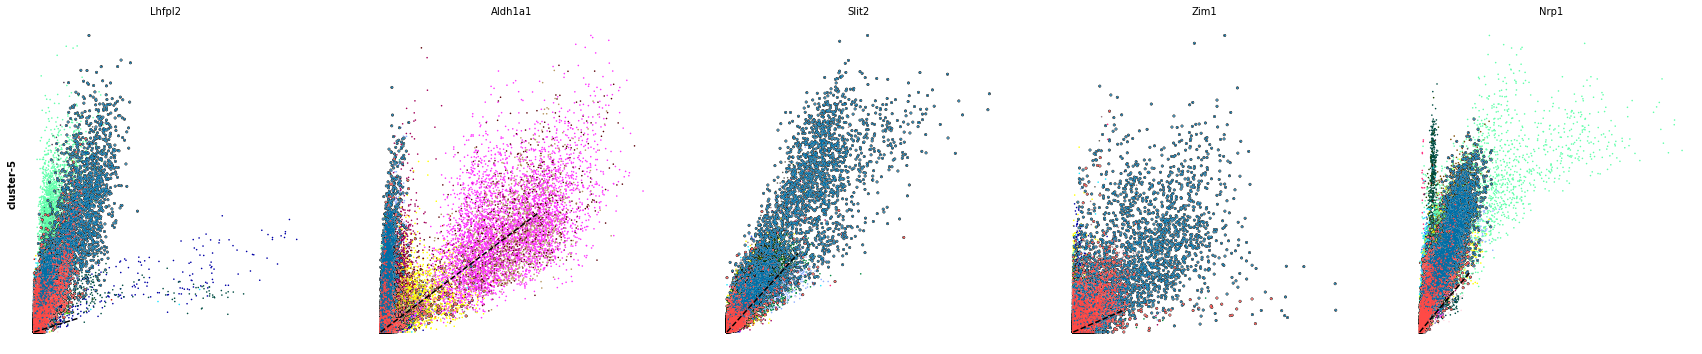

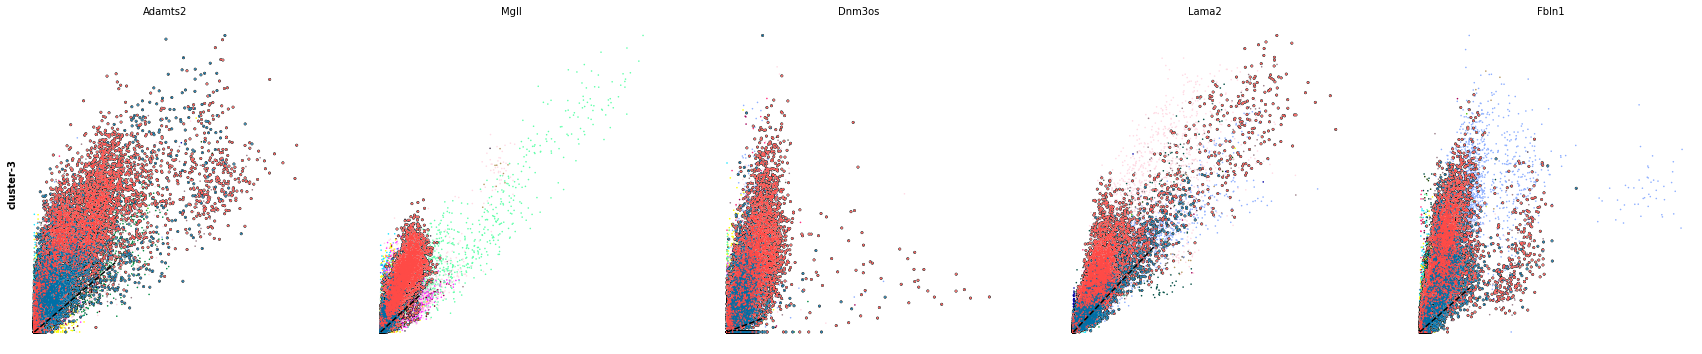

In [26]:
# From cluster 5 to cluster 3
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='5, 3')

scv.pl.scatter(sample, df['5'][:5], ylabel='cluster-5', **kwargs)
scv.pl.scatter(sample, df['3'][:5], ylabel='cluster-3', **kwargs)

The genes Ptprs, Pclo, Pam, Abcc8, Gnas, for instance, support the directionality from Ngn3 high EP (yellow) to Pre-endocrine (orange) to Beta (green).

## Velocities in cycling progenitors

The cell cycle detected by RNA velocity, is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


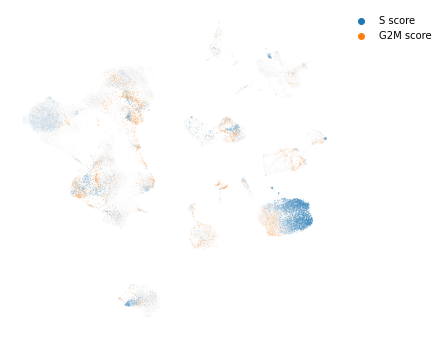

In [27]:
# Attention, the default genes are from Mouse.
# scv.tl.score_genes_cell_cycle(sample)
# scv.pl.scatter(sample, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

For the cycling Ductal cells, we may screen through S and G2M phase markers. The previous module also computed a spearmans correlation score, which we can use to rank/sort the phase marker genes to then display their phase portraits.

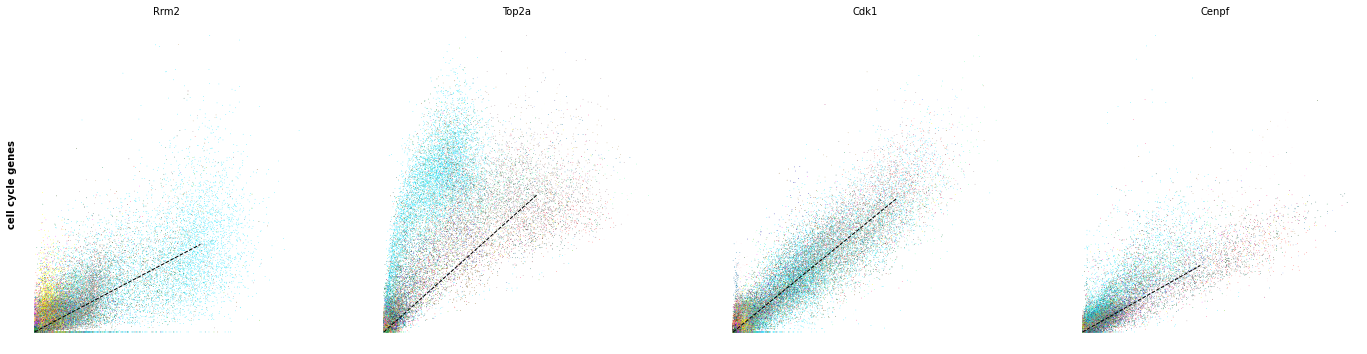

In [28]:
# s_genes, g2m_genes = scv.utils.get_phase_marker_genes(sample)
# s_genes = scv.get_df(sample[:, s_genes], 'spearmans_score', sort_values=True).index
# g2m_genes = scv.get_df(sample[:, g2m_genes], 'spearmans_score', sort_values=True).index

# kwargs = dict(frameon=False, ylabel='cell cycle genes')
# scv.pl.scatter(sample, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

Particularly Hells and Top2a are well-suited to explain the vector field in the cycling progenitors. Top2a gets assigned a high velocity shortly before it actually peaks in the G2M phase. There, the negative velocity then perfectly matches the immediately following down-regulation.

In [29]:
# Error when running this code!
# scv.pl.velocity(sample, ['Mki67', 'Top2a'], ncols=2, add_outline=True)

# Speed and coherence

Two more useful stats: - The speed or rate of differentiation is given by the length of the velocity vector. - The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


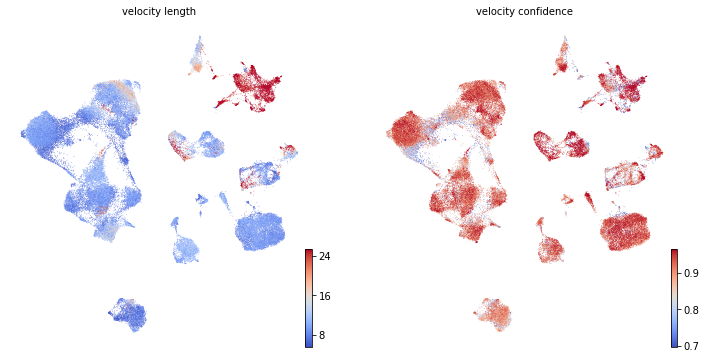

In [30]:
scv.tl.velocity_confidence(sample)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(sample, c=keys, cmap='coolwarm', perc=[5, 95])

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

On cluster-level, we find that differentiation substantially speeds up after cell cycle exit (Ngn3 low EP), keeping the pace during Beta cell production while slowing down during Alpha cell production.

In [31]:
df = sample.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

clusters,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
velocity_length,7.967500,8.478291,10.810218,8.558104,7.348505,9.753912,7.882808,10.089196,48.047684,11.468115,10.253308,7.920374,9.870699,8.103560,7.823805,10.093719,26.476419,14.450099,14.827106,15.819061,9.919893,9.075323,8.071123,9.398284,24.207661,53.495514,23.359028,24.073181,7.662424
velocity_confidence,0.863978,0.905522,0.902369,0.878487,0.847764,0.857448,0.814212,0.873677,0.880208,0.859420,0.878990,0.887530,0.889566,0.864019,0.900892,0.866261,0.829684,0.878130,0.908806,0.865045,0.929610,0.865359,0.880854,0.825777,0.872858,0.798368,0.734840,0.874266,0.921076


##  Velocity graph and pseudotime

We can visualize the velocity graph to portray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probability transitions by setting a threshold. The graph, for instance, indicates two phases of Epsilon cell production, coming from early and late Pre-endocrine cells.

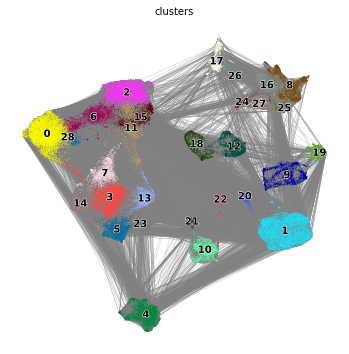

In [32]:
scv.pl.velocity_graph(sample, threshold=.1)

Further, the graph can be used to draw descendents/anscestors coming from a specified cell. Here, a pre-endocrine cell is traced to its potential fate.

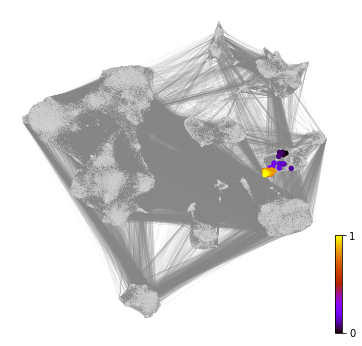

In [33]:
# how to set the starting_cell ?
x, y = scv.utils.get_cell_transitions(sample, basis='umap', starting_cell=0)
ax = scv.pl.velocity_graph(sample, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(sample, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

Finally, based on the velocity graph, a velocity pseudotime can be computed. After inferring a distribution over root cells from the graph, it measures the average number of steps it takes to reach a cell after walking along the graph starting from the root cells.

Contrarily to diffusion pseudotime, it implicitly infers the root cells and is based on the directed velocity graph instead of the similarity-based diffusion kernel.

computing terminal states
    identified 6 regions of root cells and 8 regions of end points 
    finished (0:00:51) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


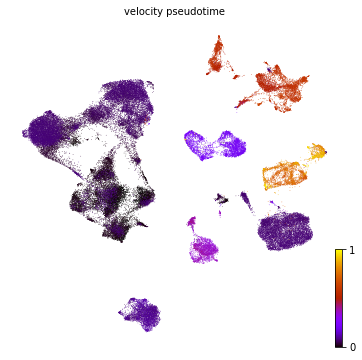

In [34]:
scv.tl.velocity_pseudotime(sample)
scv.pl.scatter(sample, color='velocity_pseudotime', cmap='gnuplot')

## PAGA velocity graph

PAGA graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. Here, PAGA is extended by velocity-inferred directionality.

In [35]:
# PAGA requires to install igraph, if not done yet.
!pip install python-igraph --upgrade --quiet

In [36]:
# this is needed due to a current bug - bugfix is coming soon.
sample.uns['neighbors']['distances'] = sample.obsp['distances']
sample.uns['neighbors']['connectivities'] = sample.obsp['connectivities']

scv.tl.paga(sample, groups='clusters')
df = scv.get_df(sample, 'paga/transitions_confidence').T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA
    finished (0:00:26) --> added
    'paga/transitions_confidence', connectivities adjacency (adata.uns)
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.16,0,0,0,0,0,0,0,0.012,0,0,0,0.028,0,0,0,0,0,0,0.014,0.039,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.074,0,0,0,0,0,0.043,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.017,0,0,0,0,0,0,0,0,0


This reads from left/row to right/column, thus e.g. assigning a confident transition from Ductal to Ngn3 low EP.

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

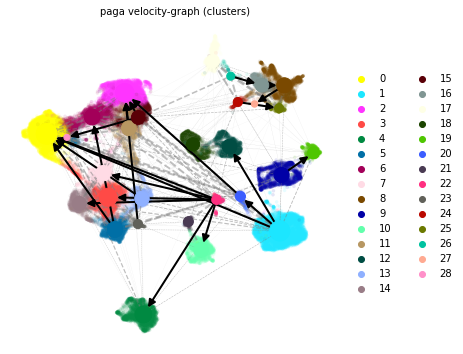

In [37]:
scv.pl.paga(sample, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

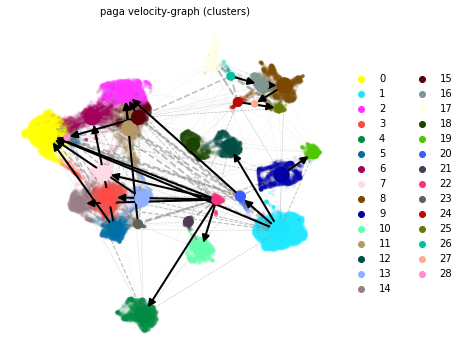

In [38]:
scv.pl.paga(sample, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, threshold = 0.015)

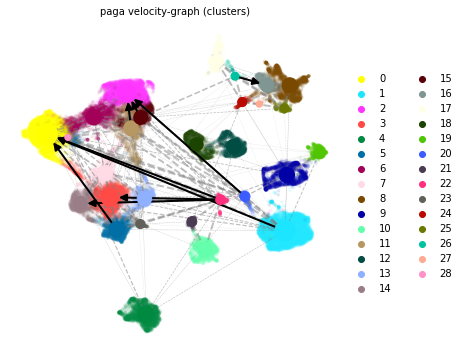

In [39]:
scv.pl.paga(sample, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, threshold = 0.05)